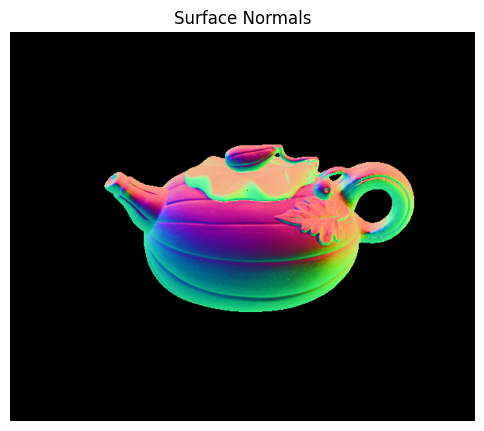

In [24]:
import os
import numpy as np
import cv2
import glob

# Set folder path
image_folder = "./DiLiGenT/pmsData/pot1PNG/"
mask_path = os.path.join(image_folder, "mask.png")

# Load binary mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
assert mask is not None, "Mask file not found."
mask = mask > 10
H, W = mask.shape
mask_flat = mask.flatten()

# Get list of image files (excluding mask and normal_gt)
image_files = sorted(glob.glob(os.path.join(image_folder, "*.png")))
image_files = [f for f in image_files if 'normal' not in f and 'mask' not in f]
num_images = len(image_files)

# Load images and apply mask
pixels_in_mask = np.sum(mask)
intensity_matrix = np.zeros((num_images, pixels_in_mask), dtype=np.float32)  # shape (num_images, N_pixels)

for i, img_file in enumerate(image_files):
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    assert img is not None, f"Image not found: {img_file}"
    intensity_matrix[i, :] = img.flatten()[mask_flat]

# Optional: Normalize per image (row-wise mean subtraction)
# Helps reduce lighting variations
intensity_matrix -= intensity_matrix.mean(axis=1, keepdims=True)

# SVD
U, S, Vt = np.linalg.svd(intensity_matrix, full_matrices=False)

# Take top-3 components
U3 = U[:, :3]
S3 = np.diag(S[:3])
V3 = Vt[:3, :]

# Estimated normals (unnormalized)
B_hat = S3 @ V3  # Shape (3, N_pixels)

# Normalize estimated normals
normals_est = B_hat / (np.linalg.norm(B_hat, axis=0, keepdims=True) + 1e-8)

# Reconstruct full normal map
normal_map = np.zeros((H * W, 3), dtype=np.float32)
normal_map[mask_flat] = normals_est.T  # shape (H*W, 3)
normal_map = normal_map.reshape((H, W, 3))

normal_mapk=normal_map
# Normalize to [0, 1] for visualization
normal_map_vis = (normal_map + 1) / 2.0
mask_3c = np.stack([mask] * 3, axis=-1)
normal_map_vis[~mask_3c] = 0.0

import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
plt.imshow(normal_map_vis)
plt.title("Surface Normals")
plt.axis("off")
plt.show()


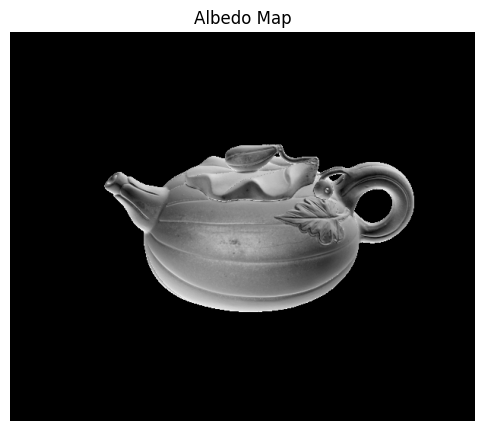

In [25]:
albedo = np.linalg.norm(B_hat, axis=0)

albedo_map = np.zeros(H * W, dtype=np.float32)
albedo_map[mask_flat] = albedo
albedo_map = albedo_map.reshape(H, W)


albedo_norm = (albedo_map - albedo_map.min()) / (albedo_map.max() - albedo_map.min())


albedo_norm[~mask] = 0.0


plt.figure(figsize=(6,6))
plt.imshow(albedo_norm, cmap='gray')
plt.title("Albedo Map")
plt.axis('off')
plt.show()


#### Angular Error

In [26]:
# Load ground truth normals
normal_gt_path = os.path.join(image_folder, "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  # shape: (H*W, 3)
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  # reshape to (H, W, 3)


# Normalize predicted and ground-truth normals
norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

# Dot product per pixel
dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

# Angular error in degrees
angular_error = np.arccos(dot_product) * (180.0 / np.pi)

# Mask out background
angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 90.16 degrees


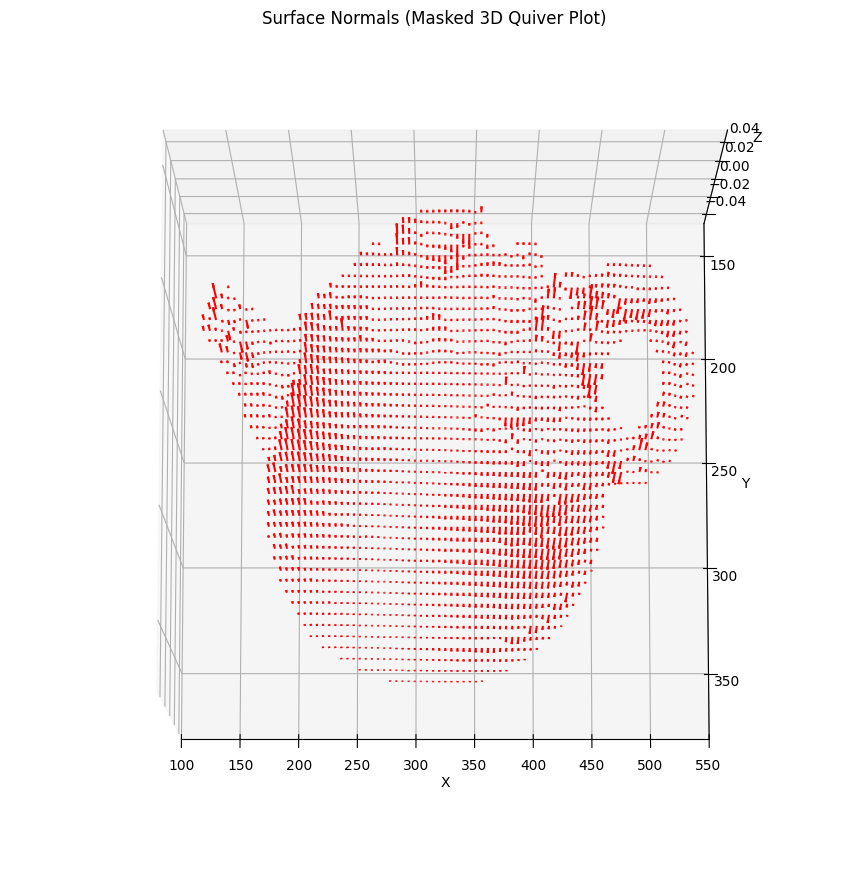

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


H, W, _ = normal_mapk.shape


# Extract components
Nx = normal_mapk[:, :, 0]
Ny = normal_mapk[:, :, 1]
Nz = normal_mapk[:, :, 2]

# Create pixel coordinate grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
Z = np.zeros_like(Nx)  

# Apply mask and downsampling
step = 5 
valid = mask[::step, ::step]


X_plot = X[::step, ::step][valid]
Y_plot = Y[::step, ::step][valid]
Z_plot = Z[::step, ::step][valid]
Nx_plot = Nx[::step, ::step][valid]
Ny_plot = Ny[::step, ::step][valid]
Nz_plot = Nz[::step, ::step][valid]


Nx_plot = -Nx_plot
Nz_plot = Nz_plot
# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot, length=0.02, normalize=True, color='r')
ax.set_xlim(550,100)
ax.view_init(elev=80, azim=90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (Masked 3D Quiver Plot)')
plt.tight_layout()
plt.show()


In [28]:
import cv2
import numpy as np
import os
from scipy.io import loadmat
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    """Integrate p, q (gradients along x, y) using Frankot-Chellappa method."""
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  # avoid divide by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))

    return z

def depth_from_normals(normals, mask):
    """Compute depth map from normals and mask."""
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6  # prevent division by zero

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    # Apply mask: set gradients outside mask to zero
    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    """Convert depth and normals to mesh and save as .ply file."""
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    # Keep only points and normals inside the mask
    points = points[mask]
    normals = normals[mask]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    # Mesh reconstruction using Ball Pivoting
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)



normal_map=normal_map_vis 

normal_map = normal_map.astype(np.float32)
normal_map[:, :, 1] *= -1  
normal_map[:, :, 2] *= -1  

normal_map = cv2.GaussianBlur(normal_map, (5, 5), 0)


# Compute depth from normals
depth = depth_from_normals(normal_map, mask)

# Save mesh
save_mesh(depth, normal_map, mask, "./generated_mesh/pot_pred_SVD.ply")



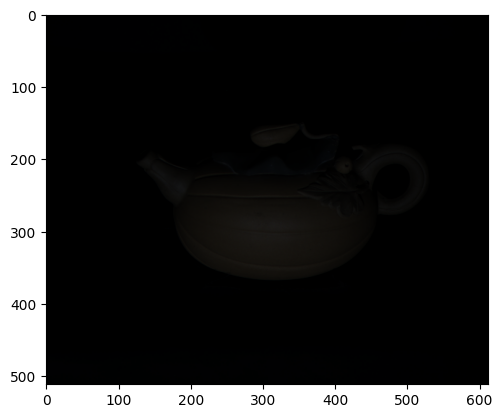

In [29]:
import matplotlib.pyplot as plt
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(color_img)

In [30]:
color_img = color_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [31]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ball pivoting for mesh
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [32]:
save_mesh(depth, normal_map, mask, "./generated_mesh/pot_colored_mesh_svd.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_pot_pred_SVD+(4).ply.gif)


#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_pot_colored_mesh_svd.ply.gif)


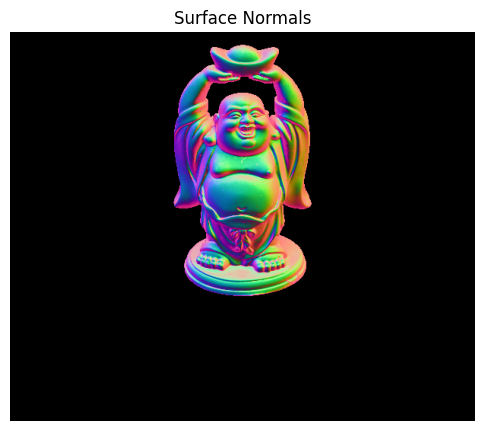

In [33]:
import os
import numpy as np
import cv2
import glob

# Set folder path
image_folder = "./DiLiGenT/pmsData/buddhaPNG/"
mask_path = os.path.join(image_folder, "mask.png")

# Load binary mask
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
assert mask is not None, "Mask file not found."
mask = mask > 10
H, W = mask.shape
mask_flat = mask.flatten()

# Get list of image files (excluding mask and normal_gt)
image_files = sorted(glob.glob(os.path.join(image_folder, "*.png")))
image_files = [f for f in image_files if 'normal' not in f and 'mask' not in f]
num_images = len(image_files)

# Load images and apply mask
pixels_in_mask = np.sum(mask)
intensity_matrix = np.zeros((num_images, pixels_in_mask), dtype=np.float32)  # shape (num_images, N_pixels)

for i, img_file in enumerate(image_files):
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    assert img is not None, f"Image not found: {img_file}"
    intensity_matrix[i, :] = img.flatten()[mask_flat]

# Optional: Normalize per image (row-wise mean subtraction)
# Helps reduce lighting variations
intensity_matrix -= intensity_matrix.mean(axis=1, keepdims=True)

# SVD
U, S, Vt = np.linalg.svd(intensity_matrix, full_matrices=False)

# Take top-3 components
U3 = U[:, :3]
S3 = np.diag(S[:3])
V3 = Vt[:3, :]

# Estimated normals (unnormalized)
B_hat = S3 @ V3  # Shape (3, N_pixels)

# Normalize estimated normals
normals_est = B_hat / (np.linalg.norm(B_hat, axis=0, keepdims=True) + 1e-8)

# Reconstruct full normal map
normal_map = np.zeros((H * W, 3), dtype=np.float32)
normal_map[mask_flat] = normals_est.T  # shape (H*W, 3)
normal_map = normal_map.reshape((H, W, 3))

normal_mapk=normal_map

# Normalize to [0, 1] for visualization
normal_map_vis = (normal_map + 1) / 2.0
mask_3c = np.stack([mask] * 3, axis=-1)
normal_map_vis[~mask_3c] = 0.0


import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
plt.imshow(normal_map_vis)
plt.title("Surface Normals")
plt.axis("off")
plt.show()


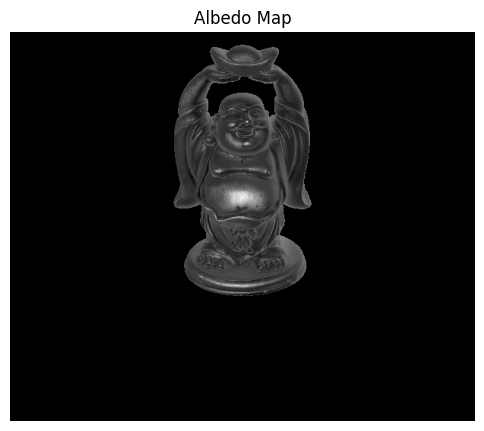

In [34]:
albedo = np.linalg.norm(B_hat, axis=0)

albedo_map = np.zeros(H * W, dtype=np.float32)
albedo_map[mask_flat] = albedo
albedo_map = albedo_map.reshape(H, W)


albedo_norm = (albedo_map - albedo_map.min()) / (albedo_map.max() - albedo_map.min())


albedo_norm[~mask] = 0.0


plt.figure(figsize=(6,6))
plt.imshow(albedo_norm, cmap='gray')
plt.title("Albedo Map")
plt.axis('off')
plt.show()


In [35]:
# Load ground truth normals
normal_gt_path = os.path.join(image_folder, "normal.txt")
normal_gt = np.loadtxt(normal_gt_path)  # shape: (H*W, 3)
normal_gt = normal_gt.reshape(mask.shape[0], mask.shape[1], 3)  # reshape to (H, W, 3)



# Normalize predicted and ground-truth normals
norm_pred = normal_mapk / (np.linalg.norm(normal_mapk, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

# Dot product per pixel
dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

# Angular error in degrees
angular_error = np.arccos(dot_product) * (180.0 / np.pi)

# Mask out background
angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 70.78 degrees


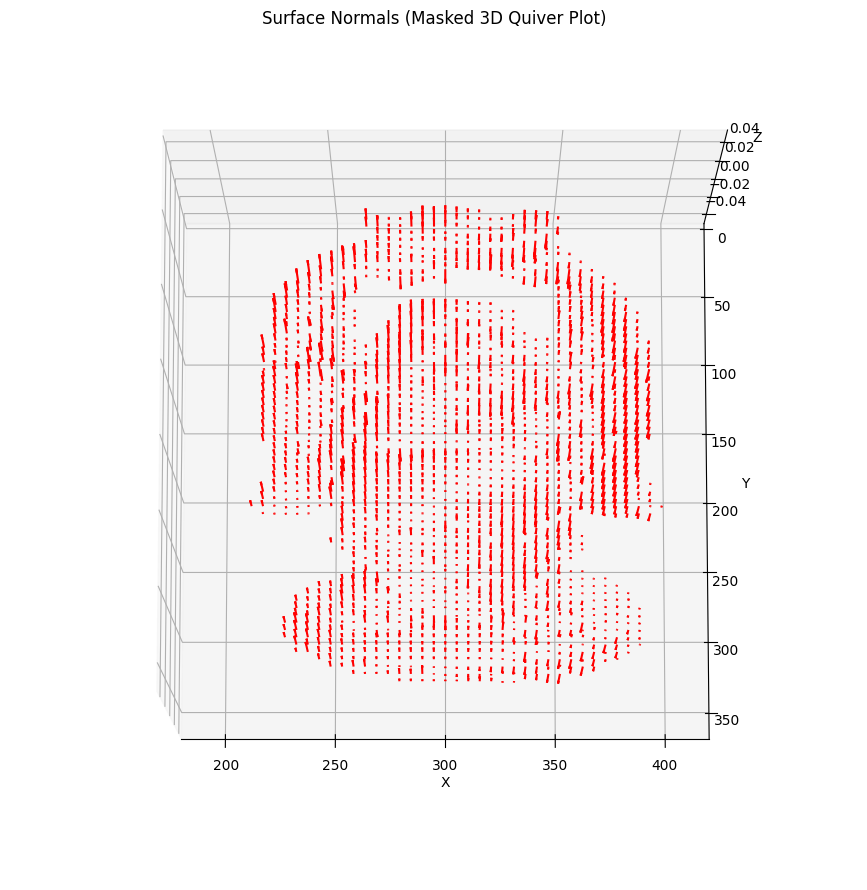

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

H, W, _ = normal_mapk.shape


# Extract components
Nx = normal_mapk[:, :, 0]
Ny = normal_mapk[:, :, 1]
Nz = normal_mapk[:, :, 2]

# Create pixel coordinate grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
Z = np.zeros_like(Nx)  

# Apply mask and downsampling
step = 5  
valid = mask[::step, ::step]


X_plot = X[::step, ::step][valid]
Y_plot = Y[::step, ::step][valid]
Z_plot = Z[::step, ::step][valid]
Nx_plot = Nx[::step, ::step][valid]
Ny_plot = Ny[::step, ::step][valid]
Nz_plot = Nz[::step, ::step][valid]


Nx_plot = -Nx_plot
Nz_plot = Nz_plot
# Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot, length=0.02, normalize=True, color='r')
ax.set_xlim(420,180)
ax.view_init(elev=80, azim=90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Normals (Masked 3D Quiver Plot)')
plt.tight_layout()
plt.show()


In [37]:
import cv2
import numpy as np
import os
from scipy.io import loadmat
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    """Integrate p, q (gradients along x, y) using Frankot-Chellappa method."""
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  # avoid divide by zero

    Z = (-1j * 2 * np.pi * wx * Px - 1j * 2 * np.pi * wy * Qy) / denom
    z = np.real(ifft2(Z))

    return z

def depth_from_normals(normals, mask):
    """Compute depth map from normals and mask."""
    nz = normals[:, :, 2]
    nz[nz == 0] = 1e-6  # prevent division by zero

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz

    # Apply mask: set gradients outside mask to zero
    p[~mask] = 0
    q[~mask] = 0

    depth = frankot_chellappa(p, q)
    return depth

def save_mesh(depth, normals, mask, filename):
    """Convert depth and normals to mesh and save as .ply file."""
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    # Keep only points and normals inside the mask
    points = points[mask]
    normals = normals[mask]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)

    # Mesh reconstruction using Ball Pivoting
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)



normal_map=normal_map_vis 

normal_map = normal_map.astype(np.float32)
normal_map[:, :, 1] *= -1  
normal_map[:, :, 2] *= -1  

normal_map = cv2.GaussianBlur(normal_map, (3, 3), 0)


# Compute depth from normals
depth = depth_from_normals(normal_map, mask)

# Save mesh
save_mesh(depth, normal_map, mask, "./generated_mesh/buddha_pred_SVD.ply")



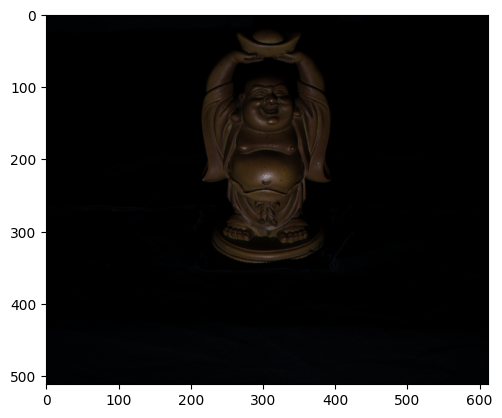

In [38]:
import matplotlib.pyplot as plt
color_img_path = os.path.join(image_folder, "./001.png")
color_img = cv2.imread(color_img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(color_img)

In [39]:
color_img = color_img.astype(np.float32) / 255.0  # Normalize to [0, 1]
colors = color_img.reshape(-1, 3)
colors = colors[mask.flatten()]


In [40]:
def save_mesh(depth, normals, mask, filename, colors=None):
    h, w = depth.shape
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    points = np.stack((xx, yy, depth), axis=2).reshape(-1, 3)
    normals = normals.reshape(-1, 3)
    mask = mask.flatten()

    points = points[mask]
    normals = normals[mask]

    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)

    # Ball pivoting for mesh
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 2 * avg_dist

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector([radius, radius * 2])
    )

    o3d.io.write_triangle_mesh(filename, mesh)


In [41]:
save_mesh(depth, normal_map, mask, "./generated_mesh/buddha_colored_mesh_svd.ply", colors=colors)


#### Mesh
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_buddha_pred_SVD.ply.gif)


#### Mesh Color
![Mesh Animation.gif](./generated_mesh/ImageToStl.com_buddha_colored_mesh_svd.ply.gif)
